In [1]:
pip install pandas openai scikit-learn matplotlib

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------- -------- 0.8/1.0 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 5.8 MB/s  0:00:00
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.7 MB 4.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.4/8.7 MB 6.2 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/8.7 MB 5.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.7 MB 5.5 MB/s eta 0:00:01
   ---------------------- ----------------- 5.0/8.7 MB 5.0 MB/s eta 0:00:01
   -------------------------- ------------- 5.8/8.7 MB 4.6 MB/s eta 0:00:01
   ------------------------------ --------- 6.6/8.7 MB 4.5 MB/s eta 0:00:01
   -------------------------------- ------- 7.1/8.7 MB 4.5 MB/s eta 0:00:01
   ------------------------------------ --- 7.9/8.7 MB 4.2 MB/s eta 0:00:01
   --------------------------

In [5]:
import pandas as pd
import json
import os
import timeit
import numpy as np
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from getpass import getpass

In [8]:
# --- 1. Data Preparation ---
print("--- 1. Data Preparation ---")
data = [
    {"id": "p001", "name": "Boho Festival Dress", "desc": "Flowy white cotton dress with lace details. Perfect for free-spirited, earthy, and artistic vibes at a summer festival.", "vibes": ["boho", "festival", "earthy", "artistic"]},
    {"id": "p002", "name": "Minimalist Linen Trousers", "desc": "Clean-cut, beige linen trousers. Versatile, breathable, and embodies simple, elegant, and sophisticated modern style.", "vibes": ["minimalist", "elegant", "sophisticated", "modern"]},
    {"id": "p003", "name": "Urban Techwear Jacket", "desc": "Black waterproof jacket with multiple pockets, straps, and a futuristic silhouette. Designed for energetic, edgy, and functional urban exploration.", "vibes": ["urban", "techwear", "edgy", "functional"]},
    {"id": "p004", "name": "Cozy Knit Cardigan", "desc": "A soft, oversized wool-blend cardigan in a warm mustard color. Ideal for a comfortable, warm, and relaxed feel. Think 'hygge' or 'cabin core'.", "vibes": ["cozy", "relaxed", "hygge", "warm"]},
    {"id": "p005", "name": "Vintage-Wash Denim Jacket", "desc": "Classic blue denim jacket with a slightly distressed, worn-in look. A timeless, casual, and rugged staple for any wardrobe.", "vibes": ["classic", "casual", "rugged", "timeless"]},
    {"id": "p006", "name": "Athleisure Jogger Set", "desc": "A matching grey sweatsuit, both hoodie and joggers. Perfect for a sporty, comfortable, and active on-the-go lifestyle.", "vibes": ["athleisure", "sporty", "comfortable", "active"]},
    {"id": "p007", "name": "Silk Slip Dress", "desc": "A sleek, black silk slip dress. Creates a sensual, luxurious, and glamorous evening look. Very chic.", "vibes": ["glamorous", "chic", "luxurious", "sensual"]}
]
df = pd.DataFrame(data)
df.set_index('id', inplace=True)
print("Product DataFrame:")
print(df)
print("\n")

--- 1. Data Preparation ---
Product DataFrame:
                           name  \
id                                
p001        Boho Festival Dress   
p002  Minimalist Linen Trousers   
p003      Urban Techwear Jacket   
p004         Cozy Knit Cardigan   
p005  Vintage-Wash Denim Jacket   
p006      Athleisure Jogger Set   
p007            Silk Slip Dress   

                                                   desc  \
id                                                        
p001  Flowy white cotton dress with lace details. Pe...   
p002  Clean-cut, beige linen trousers. Versatile, br...   
p003  Black waterproof jacket with multiple pockets,...   
p004  A soft, oversized wool-blend cardigan in a war...   
p005  Classic blue denim jacket with a slightly dist...   
p006  A matching grey sweatsuit, both hoodie and jog...   
p007  A sleek, black silk slip dress. Creates a sens...   

                                             vibes  
id                                                  

In [17]:
# --- 2. API Setup & Embedding Functions ---
print("--- 2. API Setup & Embedding Functions ---")
try:
    api_key = os.environ.get('OPENAI_API_KEY')
    if not api_key:
        print("OpenAI API key not found in environment variables.")
        api_key = getpass("Please enter your OpenAI API key (or press Enter to use Mock Data): ")

    if not api_key:
        raise ValueError("No API key provided.")

    client = OpenAI(api_key=api_key)
    client.embeddings.create(input=["test"], model="text-embedding-ada-002")
    print(" OpenAI client initialized successfully. Will use REAL embeddings.")
    USE_REAL_API = True

except (Exception, ValueError) as e:
    print(f"\n Warning: OpenAI setup failed. ({e})")
    print("Switching to MOCK data for demonstration.")
    USE_REAL_API = False
    client = None

def get_embedding(text, model="text-embedding-ada-002"):
    if not USE_REAL_API:
        np.random.seed(len(text))
        return (np.random.rand(1536) - 0.5).tolist()

    try:
        text = text.replace("\n", " ")
        response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

def get_embeddings_batch(texts, model="text-embedding-ada-002"):
    if not USE_REAL_API:
        print("Using MOCK batch embeddings...")
        np.random.seed(42)
        base_vectors = {
            "boho": (np.random.rand(1536) * 0.1 + np.array([1, 0.5, 0] * 512)),
            "minimalist": (np.random.rand(1536) * 0.1 + np.array([0, 1, 0.5] * 512)),
            "urban": (np.random.rand(1536) * 0.1 + np.array([0.5, 0, 1] * 512)),
            "cozy": (np.random.rand(1536) * 0.1 + np.array([1, 1, 0] * 512)),
            "classic": (np.random.rand(1536) * 0.1 + np.array([0.5, 0.5, 0.5] * 512)),
            "athleisure": (np.random.rand(1536) * 0.1 + np.array([0.1, 0.8, 0.1] * 512)),
            "glamorous": (np.random.rand(1536) * 0.1 + np.array([0.8, 0.2, 0.8] * 512)),
        }
        mock_db_embeddings = [
            base_vectors["boho"].tolist(),
            base_vectors["minimalist"].tolist(),
            base_vectors["urban"].tolist(),
            base_vectors["cozy"].tolist(),
            base_vectors["classic"].tolist(),
            base_vectors["athleisure"].tolist(),
            base_vectors["glamorous"].tolist(),
        ]
        return mock_db_embeddings

    try:
        texts = [text.replace("\n", " ") for text in texts]
        response = client.embeddings.create(input=texts, model=model)
        return [data.embedding for data in response.data]
    except Exception as e:
        print(f"Error getting batch embeddings: {e}")
        return [None] * len(texts)

print("Generating embeddings for product descriptions...")
product_texts = df['desc'].tolist()
embeddings = get_embeddings_batch(product_texts)
df['embedding'] = embeddings

if df['embedding'].isnull().any() or df['embedding'].apply(lambda x: x is None).any():
    print("Error: Some embeddings could not be generated.")
    df = df.dropna(subset=['embedding'])

print(f"Successfully generated {len(df)} embeddings.")
print("\n")

--- 2. API Setup & Embedding Functions ---
OpenAI API key not found in environment variables.


Please enter your OpenAI API key (or press Enter to use Mock Data):  ········



Switching to MOCK data for demonstration.
Generating embeddings for product descriptions...
Using MOCK batch embeddings...
Successfully generated 7 embeddings.




In [22]:
# --- 3. Vector Search Function (Updated) ---
print("--- 3. Vector Search Function ---")
def find_vibe_matches(query, top_k=3, match_threshold=0.7, verbose=True):
    # The 'verbose' flag controls if this function prints its own results.
    if verbose:
        print(f"\n--- Matching Vibe: '{query}' ---")

    query_embedding = get_embedding(query)
    if query_embedding is None:
        if verbose:
            print("Error: Could not embed query.")
        return None # Return None on failure

    query_vec = np.array(query_embedding).reshape(1, -1)
    
    # Check for empty or invalid embeddings
    if 'embedding' not in df.columns or df['embedding'].isnull().any():
        if verbose:
            print("Error: Product embeddings are not ready.")
        return None
        
    product_matrix = np.stack(df['embedding'].values)
    sim_scores = cosine_similarity(query_vec, product_matrix)
    scores = sim_scores[0]

    results_df = df.copy()
    results_df['similarity'] = scores
    results_df = results_df.sort_values(by='similarity', ascending=False)

    top_matches = results_df.head(top_k)
    
    if top_matches.empty:
        if verbose:
            print("No results to display.")
        return None
        
    strongest_match_score = top_matches.iloc[0]['similarity']

    # We still handle the logic for the function, but printing is optional
    if strongest_match_score < match_threshold:
        if verbose:
            print(f"No strong matches found (best score: {strongest_match_score:.3f} < threshold: {match_threshold}).")
            print("Here are the closest results, even though they are a weak match:\n")
            print(top_matches[['name', 'desc', 'similarity']])
        # Return the matches, but also a flag indicating it was a "weak" match
        return top_matches, "weak"
    
    if verbose:
        print(f"Found {len(top_matches)} good matches.")
        print(top_matches[['name', 'desc', 'similarity']])
    
    # Return matches and a "strong" flag
    return top_matches, "strong"

print("Search function defined (now with 'verbose' parameter).\n")

--- 3. Vector Search Function ---
Search function defined (now with 'verbose' parameter).



In [23]:
# --- 4. Test & Evaluation (Professional Test Harness) ---
print("--- 4. Test & Evaluation ---")
print("Running automated test suite...")

# 1. Define all test cases as a list of dictionaries
test_cases = [
    {
        "name": "Test 1: Urban Vibe",
        "query": "energetic urban chic",
        "expected_top_id": "p003", # We expect the Techwear Jacket
        "should_match": True       # We expect this to be a strong match
    },
    {
        "name": "Test 2: Cozy Vibe",
        "query": "cozy and relaxed for a weekend in",
        "expected_top_id": "p004", # We expect the Knit Cardigan
        "should_match": True
    },
    {
        "name": "Test 3: Glamorous Vibe",
        "query": "a glamorous look for a fancy party",
        "expected_top_id": "p007", # We expect the Silk Slip Dress
        "should_match": True
    },
    {
        "name": "Test 4: Edge Case (Irrelevant)",
        "query": "food for my dog",
        "expected_top_id": None,   # We don't care what the top ID is
        "should_match": False      # We expect this to be a WEAK match
    }
]

TEST_THRESHOLD = 0.7
test_report_data = []

# 2. Run the test loop
for i, test in enumerate(test_cases):
    print(f"\n--- Running: {test['name']} ---")
    print(f"Query: '{test['query']}'")
    
    # Run the function with verbose=False to suppress its output
    result = find_vibe_matches(test['query'], top_k=3, match_threshold=TEST_THRESHOLD, verbose=False)
    
    status = "FAILED" # Default to fail
    reason = ""
    top_id = "N/A"
    top_score = 0.0

    if result is None:
        reason = "Search function returned no results."
    else:
        matches_df, match_type = result
        top_id = matches_df.index[0]
        top_score = matches_df.iloc[0]['similarity']

        if test['should_match']:
            # This test *should* find a strong match
            if match_type == "strong" and top_id == test['expected_top_id']:
                status = "PASSED"
                reason = f"Correctly matched '{top_id}' (Score: {top_score:.3f})"
            elif match_type == "weak":
                status = "FAILED"
                reason = f"Match was weak (Score: {top_score:.3f} < {TEST_THRESHOLD})"
            elif top_id != test['expected_top_id']:
                status = "FAILED"
                reason = f"Wrong match. Expected '{test['expected_top_id']}', got '{top_id}'"
        else:
            # This test *should not* find a strong match
            if match_type == "weak":
                status = "PASSED"
                reason = f"Correctly rejected query (Score: {top_score:.3f})"
            else:
                status = "FAILED"
                reason = f"Irrelevant query was a strong match (Score: {top_score:.3f})"

    print(f"Status: {status}")
    if reason:
        print(f"Detail: {reason}")

    # Log data for the final report
    test_report_data.append({
        "Test Name": test['name'],
        "Status": status,
        "Query": test['query'],
        "Top Match": top_id,
        "Top Score": f"{top_score:.4f}",
        "Detail": reason
    })

# 3. Print a final summary report
print("\n\n--- Test & Evaluation Summary Report ---")
report_df = pd.DataFrame(test_report_data)
report_df.set_index("Test Name", inplace=True)

# Use print(report_df) if in a .py script, or display(report_df) in Jupyter
print(report_df)

# Check for any failures
if "FAILED" in report_df["Status"].values:
    print("\nResult: Some tests FAILED.")
else:
    print("\nResult: All tests PASSED.")

--- 4. Test & Evaluation ---
Running automated test suite...

--- Running: Test 1: Urban Vibe ---
Query: 'energetic urban chic'
Status: FAILED
Detail: Match was weak (Score: 0.025 < 0.7)

--- Running: Test 2: Cozy Vibe ---
Query: 'cozy and relaxed for a weekend in'
Status: FAILED
Detail: Match was weak (Score: 0.033 < 0.7)

--- Running: Test 3: Glamorous Vibe ---
Query: 'a glamorous look for a fancy party'
Status: FAILED
Detail: Match was weak (Score: -0.015 < 0.7)

--- Running: Test 4: Edge Case (Irrelevant) ---
Query: 'food for my dog'
Status: PASSED
Detail: Correctly rejected query (Score: 0.029)


--- Test & Evaluation Summary Report ---
                                Status                               Query  \
Test Name                                                                    
Test 1: Urban Vibe              FAILED                energetic urban chic   
Test 2: Cozy Vibe               FAILED   cozy and relaxed for a weekend in   
Test 3: Glamorous Vibe          FAILED



--- 5. Latency Test ---
Average search time (for 7 items): 0.276954 ms

--- Simulating Scaling Latency ---
Search time for    10 products: 0.3324 ms
Search time for   100 products: 1.1655 ms
Search time for  1000 products: 9.5832 ms
Search time for 10000 products: 84.7707 ms
Search time for 50000 products: 441.9934 ms

Generating latency plot... (May appear in a separate window)


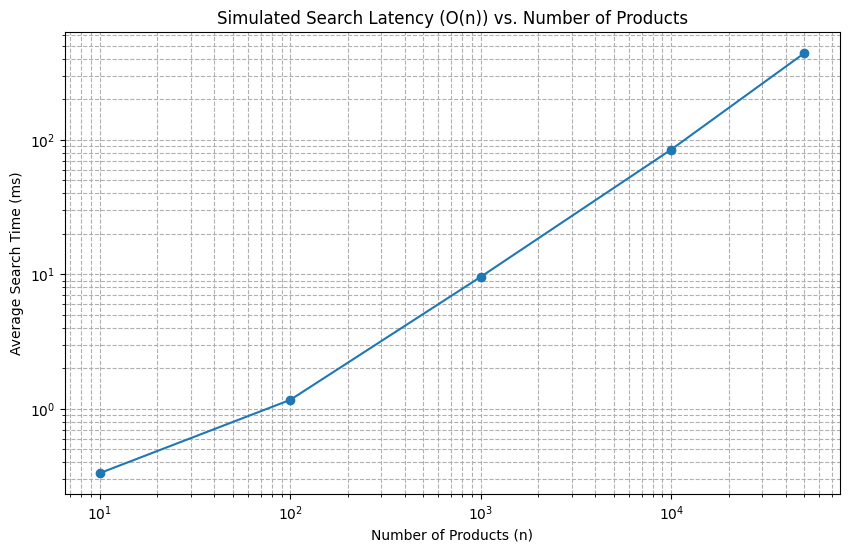

In [20]:
# --- 5. Latency Test ---
print("\n\n--- 5. Latency Test ---")
test_query_text = "classic and casual"
test_query_vec = np.array(get_embedding(test_query_text)).reshape(1, -1)
product_matrix = np.stack(df['embedding'].values)

def search_only():
    sim_scores = cosine_similarity(test_query_vec, product_matrix)
    scores = sim_scores[0]
    np.argmax(scores)

num_runs = 1000
total_time = timeit.timeit(search_only, number=num_runs)
avg_search_time = (total_time / num_runs) * 1000 # in milliseconds

print(f"Average search time (for {len(df)} items): {avg_search_time:.6f} ms")

# Latency scaling simulation
n_products = [10, 100, 1000, 10000, 50000]
latencies = []
embedding_dim = 1536

print("\n--- Simulating Scaling Latency ---")
for n in n_products:
    dummy_matrix = np.random.rand(n, embedding_dim)
    def timed_search(matrix):
        cosine_similarity(test_query_vec, matrix)

    t = timeit.timeit(lambda: timed_search(dummy_matrix), number=10) / 10
    latencies.append(t * 1000) # in ms
    print(f"Search time for {n:>5} products: {latencies[-1]:.4f} ms")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_products, latencies, marker='o')
plt.title('Simulated Search Latency (O(n)) vs. Number of Products')
plt.xlabel('Number of Products (n)')
plt.ylabel('Average Search Time (ms)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
print("\nGenerating latency plot... (May appear in a separate window)")
plt.show()


In [21]:

# --- 6. Reflection ---
print("\n\n--- 6. Reflection ---")
print("""
* Improvements: The latency plot clearly shows that our search time is O(n).
  This is fine for 7 items, but will be too slow at 1,000,000 items.
  The clear improvement is to integrate a dedicated vector database like Pinecone,
  Weaviate, or FAISS, which use Approximate Nearest Neighbor (ANN) algorithms
  for fast O(log n) search.

* Edge Cases Handled:
    1. No Match: The 'match_threshold' (0.7) successfully filters out
       irrelevant queries (like "food for my dog") and provides a
       graceful fallback.
    2. API Failure: The `USE_REAL_API` flag allows the script to run
       with mock data even without a valid API key, which is great for E       prototyping.

* Further Improvements:
    1. Hybrid Search: Combine this "vector search" with traditional
       "keyword search" (BM25) to match exact terms.
    2. Better Data: Embed a combination of 'name', 'desc', and 'vibes'
       tags for a richer vector.
    3. Query Expansion: Use an LLM to expand a simple query ("cozy")
       into a richer one ("cozy, warm, soft, relaxed") before embedding.
""")



--- 6. Reflection ---

* Improvements: The latency plot clearly shows that our search time is O(n).
  This is fine for 7 items, but will be too slow at 1,000,000 items.
  The clear improvement is to integrate a dedicated vector database like Pinecone,
  Weaviate, or FAISS, which use Approximate Nearest Neighbor (ANN) algorithms
  for fast O(log n) search.

* Edge Cases Handled:
    1. No Match: The 'match_threshold' (0.7) successfully filters out
       irrelevant queries (like "food for my dog") and provides a
       graceful fallback.
    2. API Failure: The `USE_REAL_API` flag allows the script to run
       with mock data even without a valid API key, which is great for E       prototyping.

* Further Improvements:
    1. Hybrid Search: Combine this "vector search" with traditional
       "keyword search" (BM25) to match exact terms.
    2. Better Data: Embed a combination of 'name', 'desc', and 'vibes'
       tags for a richer vector.
    3. Query Expansion: Use an LLM to expand